# Wait for another task

## Introduction
WorkGraph launch a task when its input tasks are finished. However, sometimes you want to wait for another task (not the input tasks) to finish before running the next task. For example, the input is from a data in the `context`, and you want to wait for the data to be ready.

In this tutorial, you will learn how to use `task.wait` to wait for other tasks to finish.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Here we create two `add` tasks and one `sum` task. The `sum` task will wait for the two `add` tasks to finish.

In [2]:
from aiida_workgraph import task
from aiida.orm import Float

# define add task
@task.calcfunction()
def add(x, y):
    return x + y

# define sum task
@task.calcfunction()
def sum(**datas):
    total = 0
    for data in datas.values():
        total += data.value
    return Float(total)


In [3]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("test_wait")
add1 = wg.tasks.new(add, name="add1", x=1, y=1)
add1.to_context = [["result", "data.add1"]]
add2 = wg.tasks.new(add, name="add2", x=2, y=2)
add2.to_context = [["result", "data.add2"]]
# let sum task wait for add1 and add2, and the `data` in the context is ready
sum3 = wg.tasks.new(sum, name="sum1", datas="{{data}}")
sum3.wait=["add1", "add2"]
wg.submit(wait=True)

WorkGraph node crated, PK: 842


### Check status and results


In [4]:
print("State of WorkGraph         : {}".format(wg.state))
print('Result of sum1: {}'.format(wg.tasks["sum1"].node.outputs.result.value))

State of WorkGraph         : FINISHED
Result of sum1: 6.0


Generate node graph from the AiiDA process:

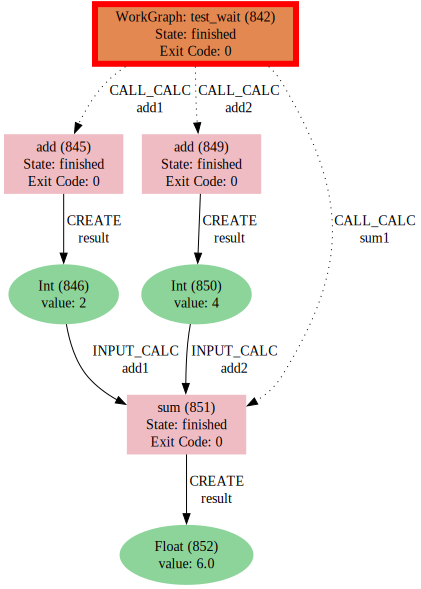

In [5]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)